In [26]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm import tqdm
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
letter = "A"
num = "1"
base_dir = r"C:\Users\ammic\Desktop\ClariGANv2\SamplesInProgress"
base_dir = os.path.join(base_dir, "train_set")

In [28]:
# Open original images
superposition_imageA = np.array(Image.open(os.path.join(base_dir, 'R1', f"R1-{letter}.png")))
superposition_imageB = np.array(Image.open(os.path.join(base_dir, 'R3', f"R3-{letter}.png")))

In [29]:
best_height = superposition_imageB.shape[0]//10
best_width = superposition_imageB.shape[1]//10

In [30]:
def pad_stack_for_best_crop(image_stack, patch_height, patch_width, constant_values=0):
    """
    Pads each layer in a 4D RGB image stack so that it can be cropped into patches of size 
    (patch_height, patch_width) without losing any pixels.

    Args:
        image_stack (numpy.ndarray): The 4D RGB image stack to be padded. Shape is (N, H, W, C).
        patch_height (int): The height of each patch.
        patch_width (int): The width of each patch.
        constant_values (int, optional): The constant value used for padding. Default is 0.

    Returns:
        numpy.ndarray: The padded 4D image stack where each layer has dimensions that are multiples of the patch size.
    """
    # Convert image stack to numpy array if necessary
    if not isinstance(image_stack, np.ndarray):
        image_stack = np.array(image_stack)
    
    # Ensure the input is a 4D array
    assert len(image_stack.shape) == 3, f"Invalid shape for image stack: {image_stack.shape}. Expected shape is (N, H, W, C)."
    
    # Get current dimensions of the image stack
    H, W, C = image_stack.shape
    
    # Calculate padding needed for height and width
    pad_height = (patch_height - (H % patch_height)) % patch_height
    pad_width = (patch_width - (W % patch_width)) % patch_width
    
    # Iterate over each layer and pad individually
    padded_stack = []
 
    layer = image_stack  # Extract each (H, W, C) layer
    padded_layer = np.pad(layer, 
                            ((0, pad_height), (0, pad_width), (0, 0)), 
                            mode='constant', constant_values=constant_values)
    padded_stack.append(padded_layer)
    
    # Convert list of padded layers back to a numpy array (4D)
    padded_stack = np.stack(padded_stack, axis=0)
    
    return padded_stack

# # Example usage
tiff_imageA = pad_stack_for_best_crop(superposition_imageA, best_height, best_width)
tiff_imageB = pad_stack_for_best_crop(superposition_imageB, best_height, best_width)
# print(f"New shape after padding: {tiff_imageA.shape}")

print(f"New shape after padding: {tiff_imageB.shape}")


New shape after padding: (1, 8305, 9130, 3)


In [31]:
print('Shape: ', tiff_imageB.shape[1:3])
print('Shape after reconstruction : ', (best_height*(tiff_imageB.shape[1]//best_height), best_width*(tiff_imageB.shape[2]//best_width)))

Shape:  (8305, 9130)
Shape after reconstruction :  (8305, 9130)


In [32]:
# Convert and permute the image
img = torch.permute(torch.from_numpy(tiff_imageA), (1, 2, 0, 3))

H, W, N, C = img.shape
patch_width = best_height
patch_height = best_width
n_rows = H // patch_height
n_cols = W // patch_width

# Crop the image to fit the patch grid
cropped_img = img[:n_rows * patch_height, :n_cols * patch_width, :, :]

# Initialize the patches tensor
patches = cropped_img.view(n_rows, patch_height, n_cols, patch_width, N, C).permute(0, 2, 1, 3, 4, 5)
patchesA = patches
print(patches.shape)  # Check the shape of the patches tensor

torch.Size([10, 12, 830, 755, 1, 3])


In [33]:
# Convert and permute the image
img = torch.permute(torch.from_numpy(tiff_imageB), (1, 2, 0, 3))

H, W, N, C = img.shape
patch_width = best_height
patch_height = best_width
n_rows = H // patch_height
n_cols = W // patch_width

# Crop the image to fit the patch grid
cropped_img = img[:n_rows * patch_height, :n_cols * patch_width, :, :]

# Initialize the patches tensor
patches = cropped_img.view(n_rows, patch_height, n_cols, patch_width, N, C).permute(0, 2, 1, 3, 4, 5)
patchesB = patches
print(patches.shape)  # Check the shape of the patches tensor

torch.Size([10, 12, 830, 755, 1, 3])


In [ ]:
import os
import numpy as np
from PIL import Image
import torch

def save_non_zero_patches(patchesA, patchesB, save_dir, letter, prefix=""):
    """
    Save non-zero patches and their overlays from two arrays using PIL.
    Images are saved into subfolders: R1, R3, and overlap.
    Overlay images are concatenated as 1x3 (imgA, imgB, overlay).
    
    Args:
        patchesA (torch.Tensor): The first tensor of patches with shape (n_rows, n_cols, patch_height, patch_width, N, C).
        patchesB (torch.Tensor): The second tensor of patches with the same shape as patchesA.
        save_dir (str): The directory path to save the images.
        prefix (str): Prefix for naming the saved images.
    """
    os.makedirs(save_dir, exist_ok=True)
    r1_dir = os.path.join(save_dir, "R1")
    r3_dir = os.path.join(save_dir, "R3")
    overlap_dir = os.path.join(save_dir, "overlap")
    discard_dir = os.path.join(save_dir, "discard")
    
    os.makedirs(r1_dir, exist_ok=True)
    os.makedirs(r3_dir, exist_ok=True)
    os.makedirs(overlap_dir, exist_ok=True)
    os.makedirs(discard_dir, exist_ok=True)

    n_rows, n_cols, patch_height, patch_width, N, C = patchesA.shape

    # Loop through each patch in both arrays
    for row in range(n_rows):
        for col in range(n_cols):
            # Extract patches from both arrays
            patchA = patchesA[row, col, :, :, 0, :].type(torch.uint8)
            patchB = patchesB[row, col, :, :, 0, :].type(torch.uint8)
            imgA = patchA.cpu().numpy() if isinstance(patchA, torch.Tensor) else patchA
            imgB = patchB.cpu().numpy() if isinstance(patchB, torch.Tensor) else patchB

            # Convert patches to PIL images
            imgA_pil = Image.fromarray(imgA)
            imgB_pil = Image.fromarray(imgB)

            # Check if patch is non-zero (any non-zero element in patch)
            if (np.mean(imgA) / 255.0 > 0.05) or (np.mean(imgB) / 255.0 > 0.02):
                # Save individual images
                imgA_pil.save(os.path.join(r1_dir, f"R1-{letter}_row{row}_col{col}_10x10.png"))
                imgB_pil.save(os.path.join(r3_dir, f"R3-{letter}_row{row}_col{col}_10x10.png"))

                # Create overlay image
                overlay = np.clip((imgA.astype(np.float32) * 0.6 + imgB.astype(np.float32) * 0.4), 0, 255).astype(np.uint8)
                overlay_pil = Image.fromarray(overlay)

                # Concatenate imgA, imgB, and overlay horizontally
                concatenated_width = imgA_pil.width * 3
                concatenated_height = imgA_pil.height
                concatenated_image = Image.new("RGB", (concatenated_width, concatenated_height))

                # Paste images side by side
                concatenated_image.paste(imgA_pil, (0, 0))
                concatenated_image.paste(imgB_pil, (imgA_pil.width, 0))
                concatenated_image.paste(overlay_pil, (imgA_pil.width * 2, 0))

                # Save concatenated image in the overlap folder
                concatenated_image.save(os.path.join(overlap_dir, f"{prefix}_row{row}_col{col}_1x3.png"))

            else:
                

                print("R1 mean: ", np.mean(imgA) / 255.0, "R3 mean: ", np.mean(imgB) / 255.0, '\n')
                # Create overlay image
                overlay = np.clip((imgA.astype(np.float32) * 0.6 + imgB.astype(np.float32) * 0.4), 0, 255).astype(np.uint8)
                overlay_pil = Image.fromarray(overlay)

                # Concatenate imgA, imgB, and overlay horizontally
                concatenated_width = imgA_pil.width * 3
                concatenated_height = imgA_pil.height
                concatenated_image = Image.new("RGB", (concatenated_width, concatenated_height))

                # Paste images side by side
                concatenated_image.paste(imgA_pil, (0, 0))
                concatenated_image.paste(imgB_pil, (imgA_pil.width, 0))
                concatenated_image.paste(overlay_pil, (imgA_pil.width * 2, 0))

                plt.figure(figsize=(8, 8))
                plt.imshow(np.array(concatenated_image))
                plt.axis('off')
                plt.title(f"Sample-{letter}_row{row}_col{col}_z_proj.png")
                plt.show()
                concatenated_image.save(os.path.join(discard_dir, f"{prefix}_row{row}_col{col}_discard.png"))



# Example usage:
save_non_zero_patches(patchesA, patchesB, save_dir=os.path.join(base_dir, f"R3-{letter}", "crops10x10"), letter=letter, prefix="R1-R3")


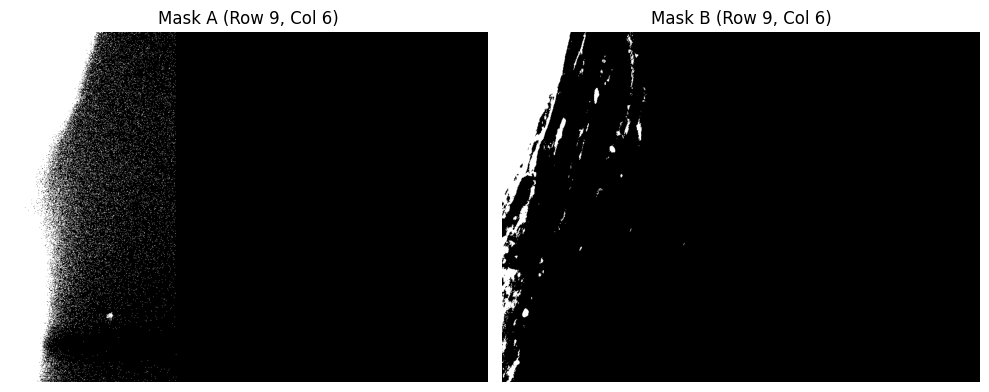

In [9]:
import cv2
def apply_masks_and_save(patchesA, patchesB, save_dir, row, col, letter, prefix=""):
    """
    Create binary masks for the specified patch R1 and R3 pair, apply the R1 mask to R3, 
    and the R3 mask to R1, then save the masked images and plot overlays.

    Args:
        patchesA (torch.Tensor): The first tensor of patches with shape (n_rows, n_cols, patch_height, patch_width, N, C).
        patchesB (torch.Tensor): The second tensor of patches with the same shape as patchesA.
        save_dir (str): The directory path to save the images.
        row (int): The row index of the patch to save.
        col (int): The column index of the patch to save.
        letter (str): A letter identifier for the patches.
        prefix (str): Prefix for naming the saved images.
    """
    os.makedirs(save_dir, exist_ok=True)
    r1_dir = os.path.join(save_dir, "R1")
    r3_dir = os.path.join(save_dir, "R3")
    overlap_dir = os.path.join(save_dir, "overlap")

    os.makedirs(r1_dir, exist_ok=True)
    os.makedirs(r3_dir, exist_ok=True)
    os.makedirs(overlap_dir, exist_ok=True)

    patchA = patchesA[row, col, :, :, 0, :].type(torch.uint8)
    patchB = patchesB[row, col, :, :, 0, :].type(torch.uint8)
    imgA = patchA.cpu().numpy() if isinstance(patchA, torch.Tensor) else patchA
    imgB = patchB.cpu().numpy() if isinstance(patchB, torch.Tensor) else patchB

    # Convert patches to grayscale for mask creation using cv2
    imgA_gray = cv2.cvtColor(imgA, cv2.COLOR_RGB2GRAY)
    imgB_gray = cv2.cvtColor(imgB, cv2.COLOR_RGB2GRAY)

    # Create binary masks
    maskA = (imgA_gray > 30).astype(np.uint8) # 30
    maskB = (imgB_gray > 20).astype(np.uint8) # 20

    # Plot masks side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(maskA, cmap="gray")
    plt.title(f"Mask A (Row {row}, Col {col})")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(maskB, cmap="gray")
    plt.title(f"Mask B (Row {row}, Col {col})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Apply masks to all RGB channels
    masked_imgA = np.clip(imgA * (maskB[..., None]), 0, 255).astype(np.uint8)
    masked_imgB = np.clip(imgB * (maskA[..., None]), 0, 255).astype(np.uint8)

    # Convert to PIL images
    masked_imgA_pil = Image.fromarray(masked_imgA)
    masked_imgB_pil = Image.fromarray(masked_imgB)

    # Save masked images in R1 and R3 folders
    masked_imgA_pil.save(os.path.join(r1_dir, f"R1-{letter}_row{row}_col{col}_10x10_masked.png"))
    masked_imgB_pil.save(os.path.join(r3_dir, f"R3-{letter}_row{row}_col{col}_10x10_masked.png"))

    # Create overlay
    overlay = np.clip((masked_imgA.astype(np.float32) * 0.6 + masked_imgB.astype(np.float32) * 0.4), 0, 255).astype(np.uint8)
    overlay_pil = Image.fromarray(overlay)

    # Concatenate images for visualization
    concatenated_width = masked_imgA_pil.width * 3
    concatenated_height = masked_imgA_pil.height
    concatenated_image = Image.new("RGB", (concatenated_width, concatenated_height))
    concatenated_image.paste(masked_imgA_pil, (0, 0))
    concatenated_image.paste(masked_imgB_pil, (masked_imgA_pil.width, 0))
    concatenated_image.paste(overlay_pil, (masked_imgA_pil.width * 2, 0))

    # Save concatenated image
    concatenated_image.save(os.path.join(overlap_dir, f"{prefix}_row{row}_col{col}_masked_overlay.png"))
# Example usage:
apply_masks_and_save(patchesA, patchesB, save_dir=os.path.join(base_dir, f"R3-{letter}", "crops10x10"), row=9, col=6, letter=letter, prefix="R1-R3")


In [24]:
base_dir

'C:\\Users\\ammic\\Desktop\\ClariGANv2\\SamplesInProgress\\train_set'

In [42]:
import os
import numpy as np
from PIL import Image
import torch

def save_specific_patch(patchesA, patchesB, save_dir, row, col, letter, prefix=""):
    """
    Save a specific patch from given row and column in both R1 and R3 arrays, along with its overlay.
    If the patch exists in the discard folder, remove it from there.

    Args:
        patchesA (torch.Tensor): The first tensor of patches with shape (n_rows, n_cols, patch_height, patch_width, N, C).
        patchesB (torch.Tensor): The second tensor of patches with the same shape as patchesA.
        save_dir (str): The directory path to save the images.
        row (int): The row index of the patch to save.
        col (int): The column index of the patch to save.
        letter (str): A letter identifier for the patches.
        prefix (str): Prefix for naming the saved images.
    """
    os.makedirs(save_dir, exist_ok=True)
    r1_dir = os.path.join(save_dir, "R1")
    r3_dir = os.path.join(save_dir, "R3")
    overlap_dir = os.path.join(save_dir, "overlap")
    discard_dir = os.path.join(save_dir, "discard")

    os.makedirs(r1_dir, exist_ok=True)
    os.makedirs(r3_dir, exist_ok=True)
    os.makedirs(overlap_dir, exist_ok=True)

    # Remove from discard folder if it exists
    discard_file = os.path.join(discard_dir, f"{prefix}_row{row}_col{col}_discard.png")
    if os.path.exists(discard_file):
        os.remove(discard_file)

    patchA = patchesA[row, col, :, :, 0, :].type(torch.uint8)
    patchB = patchesB[row, col, :, :, 0, :].type(torch.uint8)
    imgA = patchA.cpu().numpy() if isinstance(patchA, torch.Tensor) else patchA
    imgB = patchB.cpu().numpy() if isinstance(patchB, torch.Tensor) else patchB

    # Convert patches to PIL images
    imgA_pil = Image.fromarray(imgA)
    imgB_pil = Image.fromarray(imgB)

    # Save individual images
    imgA_pil.save(os.path.join(r1_dir, f"R1-{letter}_row{row}_col{col}_10x10.png"))
    imgB_pil.save(os.path.join(r3_dir, f"R3-{letter}_row{row}_col{col}_10x10.png"))

    # Create overlay image
    overlay = np.clip((imgA.astype(np.float32) * 0.6 + imgB.astype(np.float32) * 0.4), 0, 255).astype(np.uint8)
    overlay_pil = Image.fromarray(overlay)

    # Concatenate imgA, imgB, and overlay horizontally
    concatenated_width = imgA_pil.width * 3
    concatenated_height = imgA_pil.height
    concatenated_image = Image.new("RGB", (concatenated_width, concatenated_height))

    # Paste images side by side
    concatenated_image.paste(imgA_pil, (0, 0))
    concatenated_image.paste(imgB_pil, (imgA_pil.width, 0))
    concatenated_image.paste(overlay_pil, (imgA_pil.width * 2, 0))

    # Save concatenated image in the overlap folder
    concatenated_image.save(os.path.join(overlap_dir, f"{prefix}_row{row}_col{col}_1x3.png"))

# Example usage:
save_specific_patch(patchesA, patchesB, save_dir=os.path.join(base_dir, f"R3-{letter}", "crops10x10"), row=9, col=6, letter=letter, prefix="R1-R3")


In [36]:
import os
import shutil

def move_and_remove_images(row_col_list, save_dir, letter, prefix=""):
    """
    Remove images from R1 and R3 folders and transfer the corresponding overlay images
    from the overlap folder to the discard folder based on the provided row and column indices.

    Args:
        row_col_list (list of tuple): A list of (row, col) tuples specifying the images to remove and transfer.
        save_dir (str): The base directory containing the subfolders R1, R3, overlap, and discard.
        prefix (str): Prefix for naming the images (used to find the corresponding overlay images).
    """
    # Define subfolders
    r1_dir = os.path.join(save_dir, f"R1")
    r3_dir = os.path.join(save_dir, f"R3")
    overlap_dir = os.path.join(save_dir, "overlap")
    discard_dir = os.path.join(save_dir, "discard")
    
    # Ensure the discard folder exists
    os.makedirs(discard_dir, exist_ok=True)

    # Loop through each (row, col) pair
    for row, col in row_col_list:
        # Define file names
        r1_file = os.path.join(r1_dir, f"R1-{letter}_row{row}_col{col}_10x10.png")
        r3_file = os.path.join(r3_dir, f"R3-{letter}_row{row}_col{col}_10x10.png")
        overlap_file = os.path.join(overlap_dir, f"{prefix}_row{row}_col{col}_1x3.png")
        discard_file = os.path.join(discard_dir, f"{prefix}_row{row}_col{col}_1x3.png")

        # Remove R1 and R3 files if they exist
        if os.path.exists(r1_file):
            os.remove(r1_file)
            print(f"Removed: {r1_file}")
        else:
            print(f"File not found: {r1_file}")

        if os.path.exists(r3_file):
            os.remove(r3_file)
            print(f"Removed: {r3_file}")
        else:
            print(f"File not found: {r3_file}")

        # Move the overlay file to the discard folder if it exists
        if os.path.exists(overlap_file):
            shutil.move(overlap_file, discard_file)
            print(f"Moved: {overlap_file} to {discard_file}")
        else:
            print(f"File not found: {overlap_file}")



discard_list = [(0,4),(0,5),(0,7),
                (0,8),(0,10),(0,9),
                (1,3),(1,10),(2,1),
                (2,2),(2,9),(2,10),
                (3,1),(3,9),(4,0),
                (5,0),(5,1),(6,0),
                (7,9),(8,5),(8,9)]

move_and_remove_images(row_col_list=discard_list, save_dir=os.path.join(base_dir, f"R3-{letter}", "crops10x10"), letter=letter, prefix="R1-R3")


File not found: C:\Users\ammic\Desktop\ClariGANv2\SamplesInProgress\train_set\R3-A\crops10x10\R1\R1-A_row0_col4_10x10.png
File not found: C:\Users\ammic\Desktop\ClariGANv2\SamplesInProgress\train_set\R3-A\crops10x10\R3\R3-A_row0_col4_10x10.png
File not found: C:\Users\ammic\Desktop\ClariGANv2\SamplesInProgress\train_set\R3-A\crops10x10\overlap\R1-R3_row0_col4_1x3.png
File not found: C:\Users\ammic\Desktop\ClariGANv2\SamplesInProgress\train_set\R3-A\crops10x10\R1\R1-A_row0_col5_10x10.png
File not found: C:\Users\ammic\Desktop\ClariGANv2\SamplesInProgress\train_set\R3-A\crops10x10\R3\R3-A_row0_col5_10x10.png
File not found: C:\Users\ammic\Desktop\ClariGANv2\SamplesInProgress\train_set\R3-A\crops10x10\overlap\R1-R3_row0_col5_1x3.png
Removed: C:\Users\ammic\Desktop\ClariGANv2\SamplesInProgress\train_set\R3-A\crops10x10\R1\R1-A_row0_col7_10x10.png
Removed: C:\Users\ammic\Desktop\ClariGANv2\SamplesInProgress\train_set\R3-A\crops10x10\R3\R3-A_row0_col7_10x10.png
Moved: C:\Users\ammic\Desktop\

# Sample A discard list 10x10:

discard_list = [(0,4),(0,5),(0,10),
                (1,3),(1,10),(2,1),
                (2,2),(2,10),(3,1),
                (4,0),(5,0),(6,0),
                (7,9),(8,5),(8,9)]

# Sample B discard list 10x10:

discard_list = [(0,3),(0,4),(0,5),
                (0,6),(0,7),(1,2),
                (1,3),(1,4),(1,7),
                (2,1),(2,2),(3,0),
                (3,1),(4,0),(5,0),
                (6,0),(7,0),(8,0),
                (8,1),(8,8),(9,1),
                (9,2),(9,7),(10,4),
                (10,5)]

# Sample C discard list 10x10:

discard_list = [(0,10),(4,14)
                ]

# Sample F discard list 10x10:

discard_list = [(1,7),(4,0),(4,10),
                (5,1),(5,2),(5,12),
                (6,11)]

# Sample G discard list:
discard_list = [(0,0),(1,3),(1,4),
                (1,8),(2,9),(3,4),
                (3,9),(4,9),(5,0),
                (5,9),(6,0),(9,7)]

# Sample H part 0  10x10 discard list:

discard_list = [(0,7),(1,5),(1,6),
                (1,7),(2,4),(6,5),
                (7,2)]

# Sample H part 1 10x10 discard list:

discard_list = [(3,0),(3,9),(4,0),
                (4,10),(5,0),(5,1),
                (5,10),(6,0),(6,1),
                (6,2),(6,3),(6,4),
                (6,5),(6,6),(6,10),
                (7,3),(7,4)]

# Sample I discard list 10x10:

discard_list = [(0,4),(3,2),(4,1),
                (5,0),(5,1),(5,5),
                (7,6),(9,0),(9,6),
                (12,3),(13,4)]


# Sample J discard list 10x10:

discard_list = [(0,4),(0,6),(0,7),
                (2,4),(2,5),(3,3),
                (3,4),(3,5),(4,3),
                (4,4),(4,5),(5,3),
                (5,4),(5,5),(5,6),
                (5,8),(6,4),(6,5),
                (6,6),(6,7)]

# Sample D discard list 10x10:

discard_list = [(0,0),(0,1),(0,4),
                (4,3),(7,9),(8,8),
                ]

# Sample E discard list 10x10:

discard_list = [(1,9),(2,0),(2,1),
                (2,10),(3,10),(4,11),
                (5,0),(5,1),(6,0),
                (6,1),(7,11)
                ]

# Sample K discard list 10x10:

None

# Sample L discard list 10x10:

discard_list = [(0,1),(3,1),(5,6),
                (6,0),(6,6),(7,1),
                (7,6),(9,4),(10,2),
                (10,4),(10,5),(10,6),
                (11,2),(11,3)]